## **Basic RAG system**

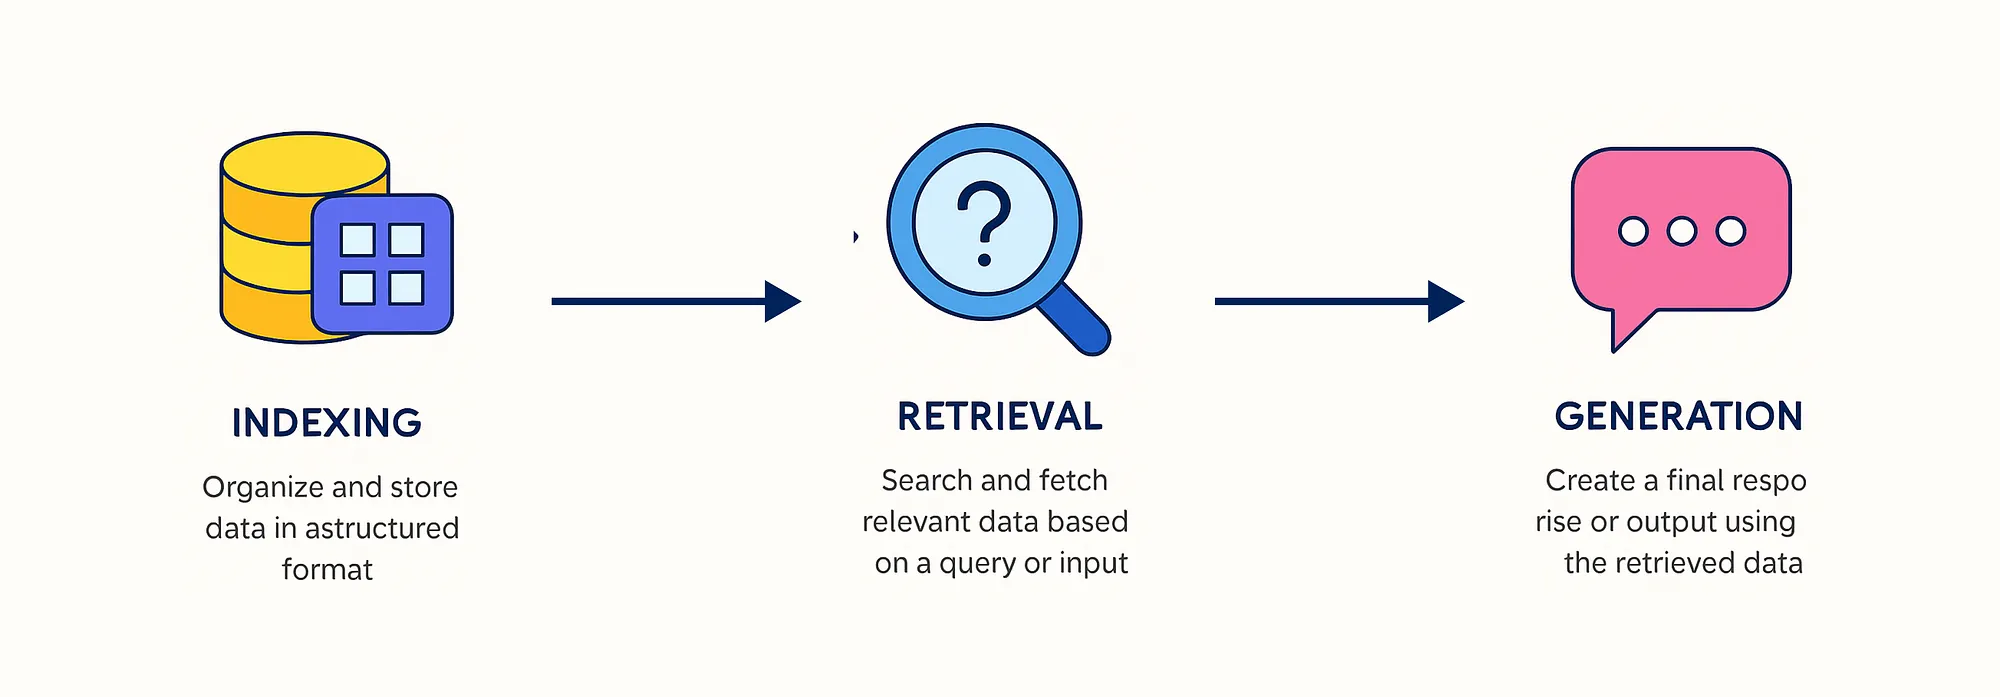

# **Indexing Phase**![1_dnSg_QmGd4J030_bznvUPw[1].png](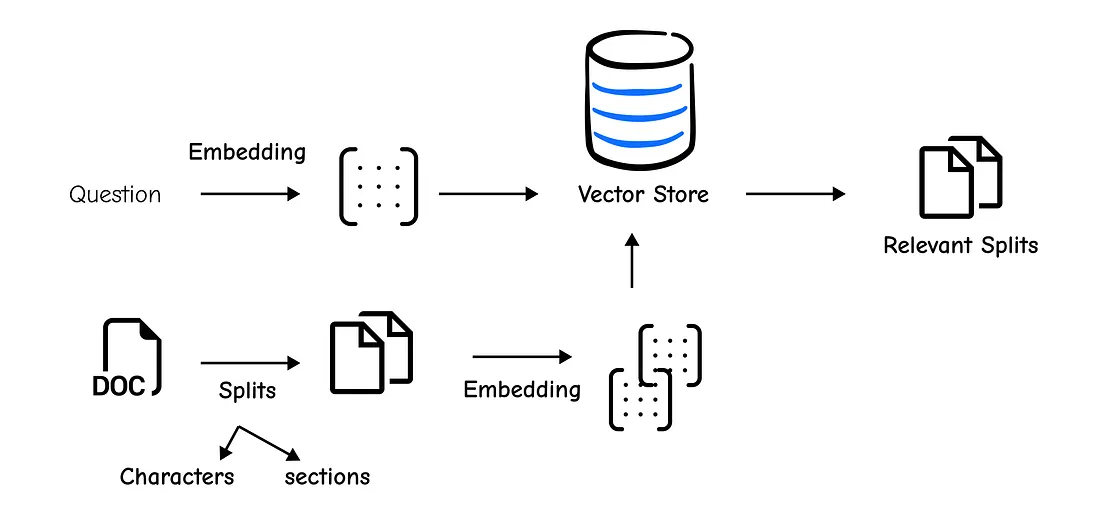)

In [59]:
%pip install bs4 langchain-text-splitters langchain_core langchain langchain-huggingface sentence_transformers langchain_chroma langchain-groq

In [60]:
from bs4 import BeautifulSoup
import requests
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
import getpass
import os
from langchain_groq import ChatGroq

In [61]:
#Lets start with
#Scraping our website("https://lilianweng.github.io/posts/2023-06-23-agent/") for text
#Splitting it into Chunks
#Embedding the Chunks and
#Storing in our Vectorstore

In [62]:
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [63]:
# Scraping the Text from website using BeautifulSoup
html = requests.get(url).text
soup = BeautifulSoup(html)
text = soup.text

In [64]:
# Using RecursiveCharacterTextSplitter to split our documents into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_text(text)
# Vectorstore only accept list of Document Objects to work with
# Therefore we convert Chunks to list of Document Object here
docs = [Document(page_content=chunk) for chunk in chunks]

In [65]:
# Initializing the Embedding Model we will use for embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [66]:
# Initializing our Chroma Vectorstore
vectorstore = Chroma(
    embedding_function=embeddings
)

In [67]:
vectorstore

In [68]:
# Now let us add our documents into the vectorstore
vectorstore.add_documents(documents=docs)

['cbdc9624-7b29-4f48-89ac-53f58b7a60ca',
 '4167ddd9-ce51-47a3-b69e-affccfb232ce',
 '9f5b2c7d-a2de-49f3-a84d-d5fe3c3fc76e',
 '51f906d0-209c-4f50-8ec7-819dd9f30b0d',
 'd13036a0-be60-4a18-95ad-28227f75e1e3',
 '55c855bb-e43d-453c-8969-47e20555a6fb',
 '91477f8e-5adb-43dc-89fb-43b95a1453dc',
 'cdb99b46-c026-4d08-b2b0-2fa1d9171f3d',
 'a3499f02-0065-4582-ae43-b44fa5b873aa',
 '29c7a6a4-a4a9-4e92-a17e-519c946b0e88',
 '69f1d2d7-5ce6-421b-87ef-05587284bb7c',
 '5848b31f-a562-45d9-aab3-9387747e58da',
 '8f88d975-57eb-4162-9c44-c2ca89d187a0',
 '06a8d59e-4119-401d-bdce-afe753cc5c18',
 '30ffd66b-b1b8-4374-a232-5987dff5a13e',
 '38d849e3-69ab-4608-9169-805983d67168',
 'fd002d6e-a87f-406c-950d-bb1181eca7c0',
 '04d21b65-e88e-430d-8e12-52c824e39cd6',
 '8bdf91dc-2de3-4969-a1c1-1a3f6bd6f79e',
 'fa1ecbe6-31a8-44ae-88c6-d7e80bdcf0e2',
 '384301e6-bd32-4c23-8033-6a34093f2453',
 '1e415819-fe54-4b1e-8884-5a6722d20438',
 '4b7271d1-18d4-431b-92cd-cf76f572d4a4',
 '75efe299-4584-46c8-b5ea-9ba1f1ea891b',
 '7815e80e-4879-

# **RETRIEVAL PHASE**![1_jtf1FoBGfpnDPTTu9N94Wg[1].png](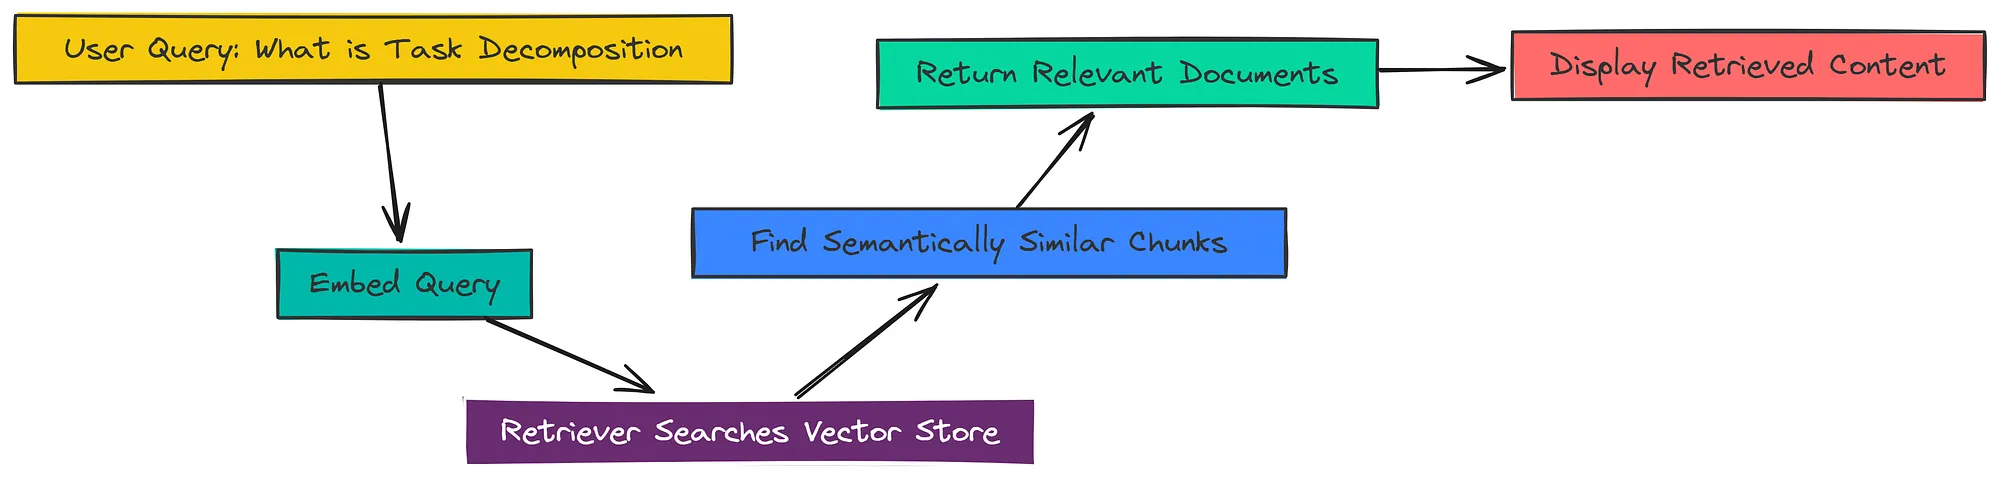)

In [69]:
# Declare our Query
# Run similarity_search
# Show the Retrieved Docs

In [70]:
query = "What is Task Decomposition"

In [71]:
# Retrieving Docs similar to our Query
retrieved_docs = vectorstore.similarity_search(query)

**GENERATION**![1_0K6ognTAEOJQmb6KDL9wBw[1].png](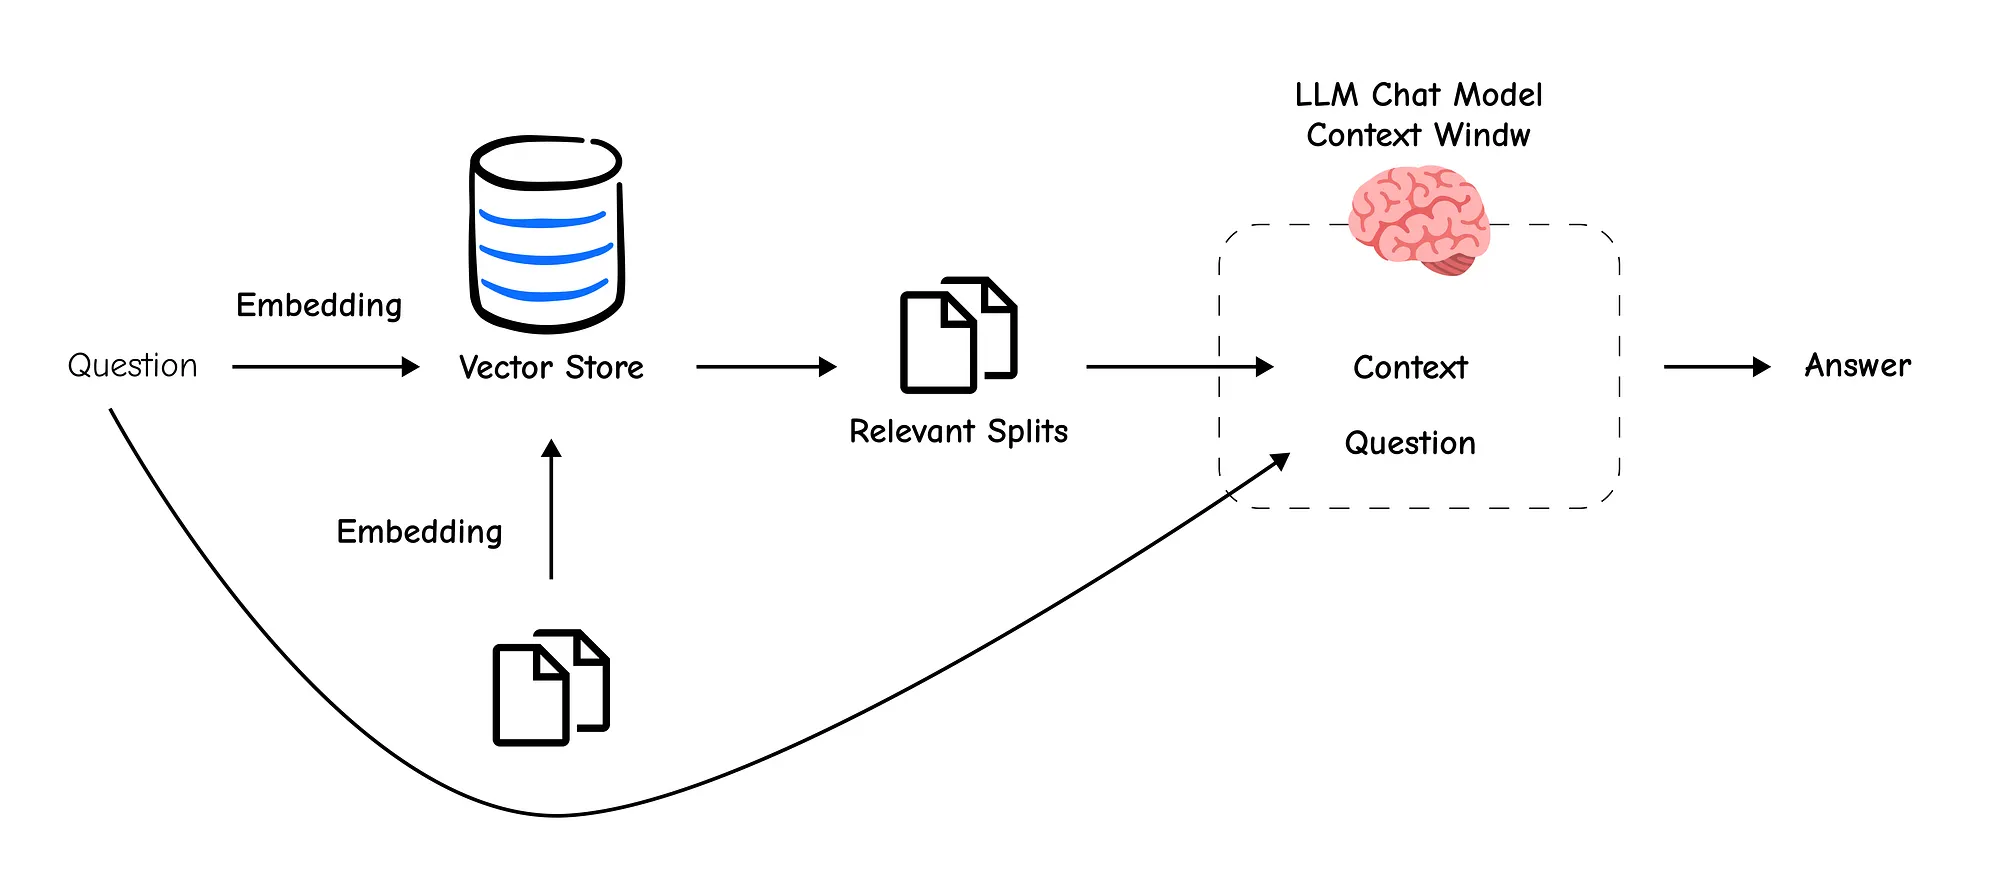)

In [72]:
# Declare a Prompt to guide our Model Behaviour
# Initialize a LLM
# Pass the prompt with context and query to llm

In [73]:
# Initializing our Prompt Template for Behaviour of our Model
prompt_template = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant for question-answering tasks. Use the following pieces
of {context} to answer the question. If you dont know the answer,
just say that you dont know. Use three sentences maximum and keep the
answer concise."""),
    ("human", "{query}")
])

In [74]:
# Concatenating the page content from retrieved docs into context
context = ""
for doc in retrieved_docs:
  context += doc.page_content

In [75]:
# Passing Context and Query to our prompt
prompt = prompt_template.format_messages(context=context, query=query)
prompt

[SystemMessage(content='You are an assistant for question-answering tasks. Use the following pieces\nof Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable plan

In [117]:
# Taking the API Key
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [77]:
# Instantiate our model object
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [78]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7a143f8b72c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a143cf52360>, model_name='llama-3.1-8b-instant', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [79]:
response = llm.invoke(prompt)

In [80]:
response.content

'Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks or steps. This involves identifying the individual components of the task, determining the necessary actions to complete each component, and organizing them in a logical order to achieve the overall goal.'

**ADVANCE QUERY TRANSFORMATIONS**

In [81]:
# A query might be too specific, too broad, or use different vocabulary than our source documents,
# leading to poor retrieval results. The solution isn’t to blame the user, it’s to make our system smarter.
# Query Transformation is a set of powerful techniques designed to re-write, expand, or break down the original question
# to significantly improve retrieval accuracy.

**1. Multi-Query Optimization**![1_GjZoAISn6Jv3CBH87zUNPA[1].png](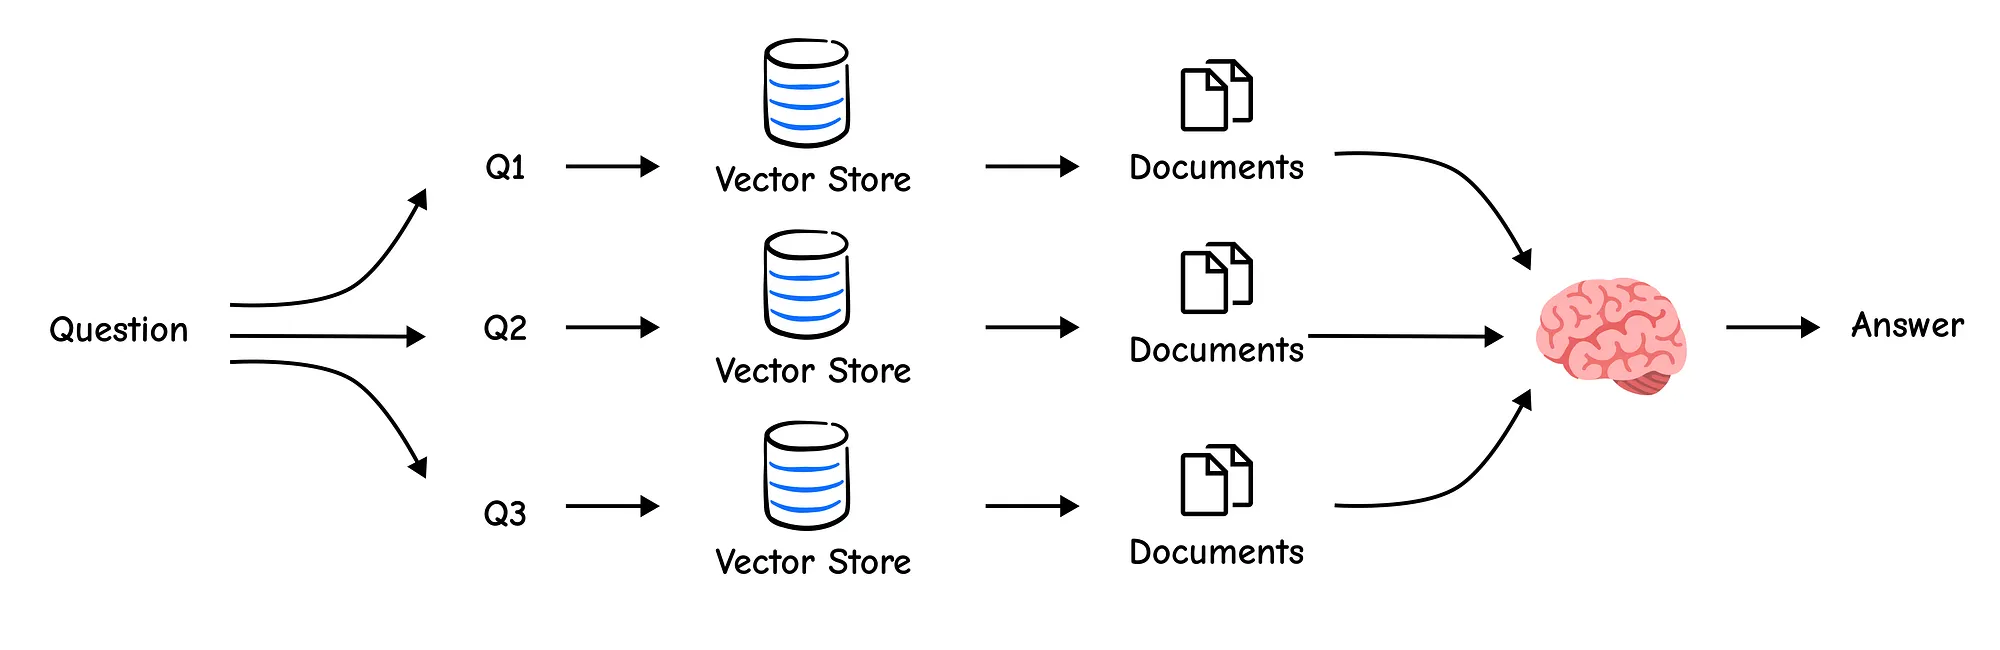)

In [82]:
# Take the Query
# Rewrite our Query into three different queries using prompt and llm
# Retrieve Docs using all three queries
# Finally combine them to generate the answer

In [83]:
query = "What is Task Decomposition"

In [84]:
# Defining our Chat template for multi_query optimization
multi_query_template = ChatPromptTemplate(
    [
        ("system", """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Give only Queries.
Provide these alternative questions separated by newlines. Original question: {question}""")
    ]
)

In [85]:
# Passing our query to chat template
multi_query_prompt = multi_query_template.format_messages(question=query)

In [86]:
multi_query_prompt

[SystemMessage(content='You are an AI language model assistant. Your task is to generate five\ndifferent versions of the given user question to retrieve relevant documents from a vector\ndatabase. By generating multiple perspectives on the user question, your goal is to help\nthe user overcome some of the limitations of the distance-based similarity search.\nGive only Queries.\nProvide these alternative questions separated by newlines. Original question: What is Task Decomposition', additional_kwargs={}, response_metadata={})]

In [87]:
# Generating Multiple queries using llm
queries = llm.invoke(multi_query_prompt)

In [88]:
queries

AIMessage(content='What are the key components of Task Decomposition techniques?\n\nHow does Task Decomposition differ from other problem-solving strategies?\n\nWhat are the benefits of using Task Decomposition in complex problem-solving?\n\nCan you provide examples of Task Decomposition in real-world applications?\n\nWhat are the challenges associated with implementing Task Decomposition in dynamic environments?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 112, 'total_tokens': 177, 'completion_time': 0.247197882, 'completion_tokens_details': None, 'prompt_time': 0.006143583, 'prompt_tokens_details': None, 'queue_time': 0.044585723, 'total_time': 0.253341465}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_6b5c123dd9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b3095-36b2-7650-a77c-ae749fe14a60-0', usage_metadata={'input_tokens': 112, 'output_t

In [89]:
# Splitting our queries for passing it to retriever
list_queries = [query for query in queries.content.split("\n\n")]
list_queries

['What are the key components of Task Decomposition techniques?',
 'How does Task Decomposition differ from other problem-solving strategies?',
 'What are the benefits of using Task Decomposition in complex problem-solving?',
 'Can you provide examples of Task Decomposition in real-world applications?',
 'What are the challenges associated with implementing Task Decomposition in dynamic environments?']

In [90]:
# Let us retrieve the page_content from every doc retrieved to form our Context
context = ""
set_of_docs = set()
for query in list_queries:
  docs = vectorstore.similarity_search(query)
  for doc in docs:
    if doc.id not in set_of_docs:
      context += doc.page_content
      set_of_docs.add(doc.id)

In [91]:
docs

[Document(id='697b36ed-9b4e-40f5-94eb-23992341a504', metadata={}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in c

In [92]:
context

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#Task deco

In [93]:
set_of_docs

{'52eb1d1d-03e7-43cb-95fb-0d92a303c4d6',
 '55c855bb-e43d-453c-8969-47e20555a6fb',
 '697b36ed-9b4e-40f5-94eb-23992341a504',
 '8a2856f3-e10c-4c62-a797-6a8d92b44f99',
 'bb14e160-d7b4-4203-9460-c158efed92ad',
 'd13036a0-be60-4a18-95ad-28227f75e1e3'}

In [94]:
# Passing our context to create new prompt for Multi-query Optimization
prompt = prompt_template.format_messages(context=context, query=query)
prompt

[SystemMessage(content='You are an assistant for question-answering tasks. Use the following pieces\nof Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable plan

In [95]:
# Generating our response for Multi-Query Optimization
response = llm.invoke(prompt)
response

AIMessage(content='The challenges associated with implementing Task Decomposition in dynamic environments include:\n\n1. **Adapting to changing conditions**: Task Decomposition models struggle to adjust plans when faced with unexpected errors or changes in the environment.\n2. **Limited context capacity**: The restricted context capacity of Large Language Models (LLMs) limits the inclusion of historical information, making it difficult to incorporate new information and adapt to changing conditions.\n3. **Exploring the solution space**: Planning over a lengthy history and effectively exploring the solution space remains challenging, making it difficult to find optimal solutions in dynamic environments.\n4. **Robustness and flexibility**: LLMs are less robust compared to humans, who can learn from trial and error, making it essential to develop more robust and flexible Task Decomposition models.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt

**2. RAG FUSION**![1_qIJlH2bVjc1ZZflcniuHCw[1].png](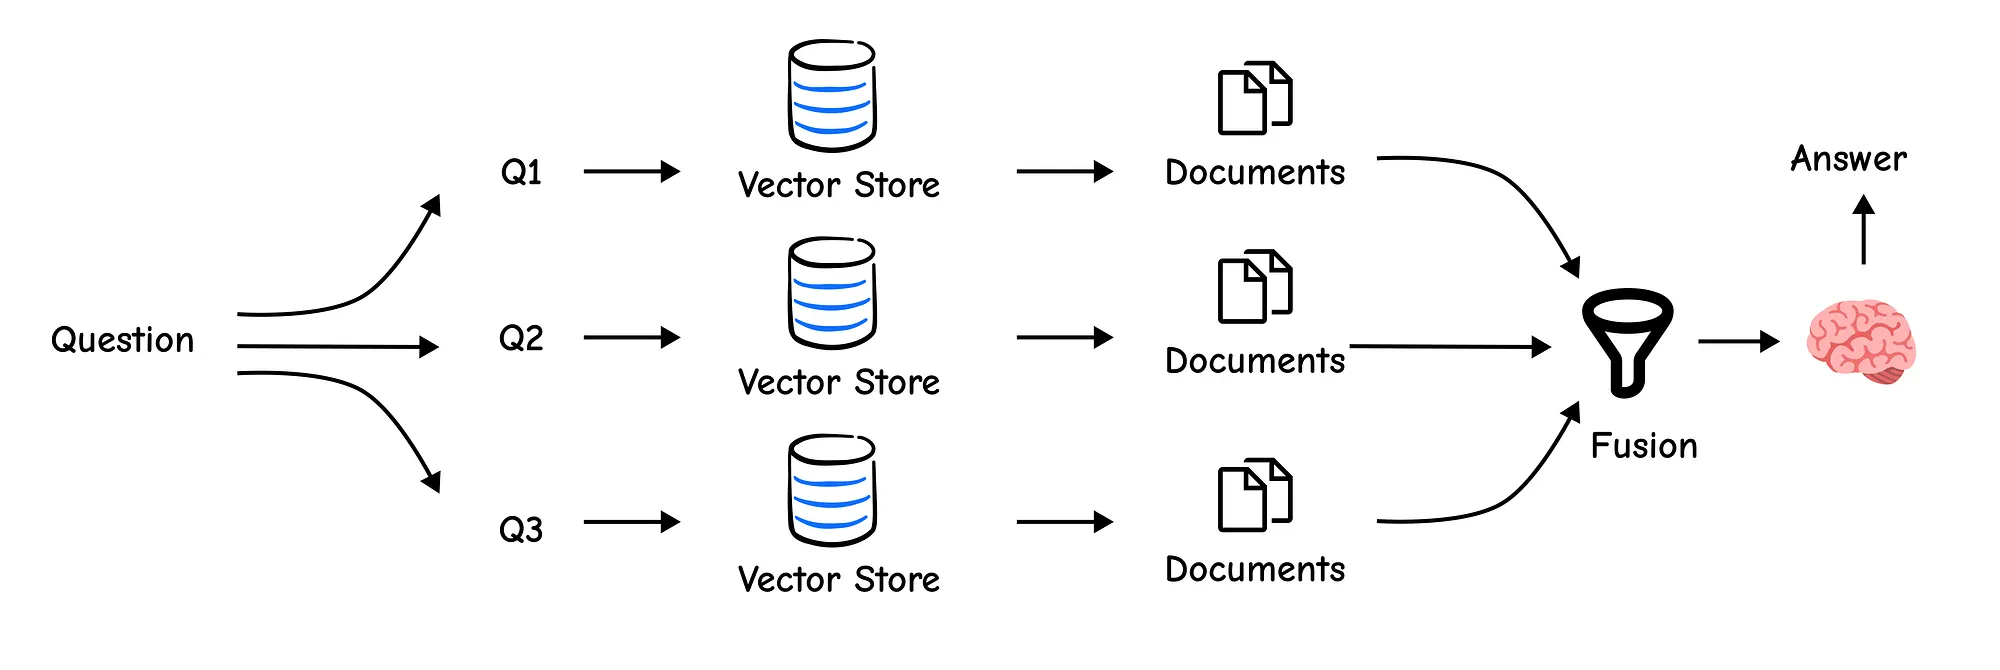)

In [96]:
# Multi-Query Optimization treats all Documents Equally
# What if one is more relevant than other
# Rag Fusion takes the relevance of document into consideration

In [97]:
# RAG-Fusion improves on Multi-Query by re-ranking them using a technique called Reciprocal Rank Fusion (RRF).
# RRF boosts the score of documents that appear consistently high across different result lists,
# Pushing the most relevant content to the top.

In [98]:
# Generate Multiple queries of the same query(We will use above one)
# RANK and SORT them according to RRF(Reciprocal Rag Fusion)
# Pass the context to prompt and generate queries

In [99]:
list_queries

['What are the key components of Task Decomposition techniques?',
 'How does Task Decomposition differ from other problem-solving strategies?',
 'What are the benefits of using Task Decomposition in complex problem-solving?',
 'Can you provide examples of Task Decomposition in real-world applications?',
 'What are the challenges associated with implementing Task Decomposition in dynamic environments?']

In [100]:
# Dictionary for ranking of every Doc retrieved
fused_scores = {}
k = 60 # Smoothing Constant

for query in list_queries:
  docs = vectorstore.similarity_search(query)
  for rank, doc in enumerate(docs):
    if doc.page_content in fused_scores:
      fused_scores[doc.page_content] += 1 / (rank + k)
    else:
      fused_scores[doc.page_content] = 1 / (rank + k)


In [101]:
fused_scores

{'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#': 0.165

In [102]:
# Reranking our Docs for the scores they receive
reranked_results = [
        str(doc.page_content)
        for doc.page_content in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

In [103]:
reranked_results

['(\'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\\nSelf-Reflection#\

In [104]:
# Creating context from our Docs
context = ""
for result in reranked_results:
  context += result

In [105]:
# Prompt for Rag-Fusion
prompt = prompt_template.format_messages(context=context, query=query)

In [106]:
response = llm.invoke(prompt)
response.content

'Implementing Task Decomposition in dynamic environments poses several challenges, including adapting to unexpected changes, adjusting plans in real-time, and handling uncertainty and incomplete information. Additionally, the complexity of the environment and the need for robustness and flexibility in planning can make it difficult to achieve effective task decomposition. This can lead to decreased performance and reliability in dynamic environments.'

**3. DECOMPOSITION**![1_oYttQUN_G0J_TZtigWjsGQ[1].png](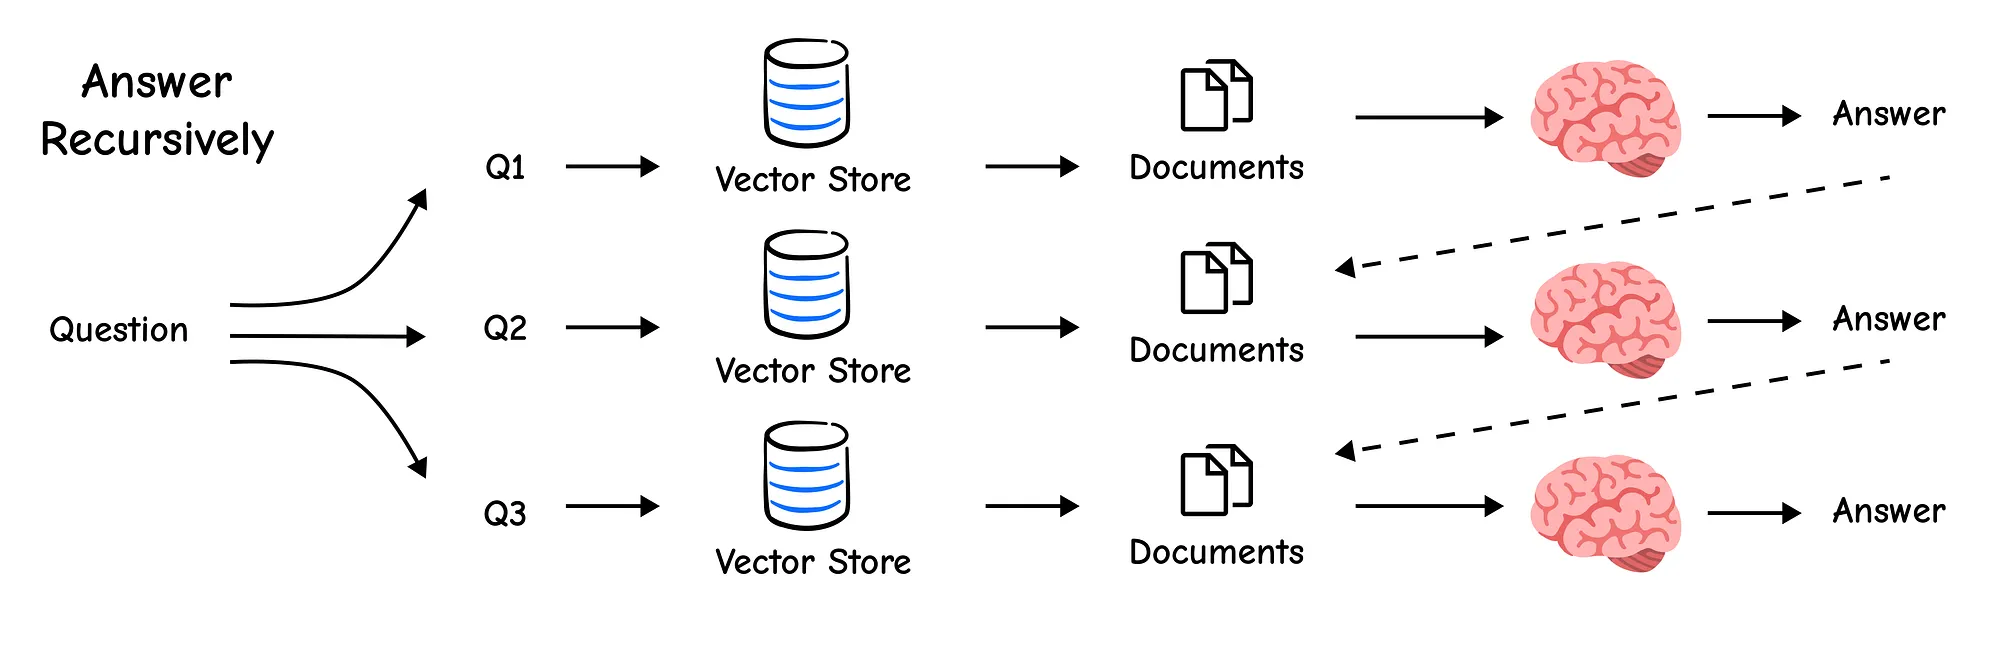)

In [107]:
# Break down Complex Query into Sub-questions
# For each Sub-question , Generate the Answer
# Attach these answer to the context of next question and generate Answer again
# Genereate the Final Answer

In [108]:
query = "What are the main components of an LLM-powered autonomous agent system?"

In [109]:
# Prompt template to generate Sub Questions from our Question
decomposition_template = ChatPromptTemplate(
    [
        ("system", """ You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation.Only give the queries.\n
Generate multiple search queries related to: {question} \n
Output (3 queries):""")
    ]
)

In [110]:
prompt = decomposition_template.format_messages(question=query)

In [111]:
sub_questions = llm.invoke(prompt)
sub_questions.content

'- What are the key components of a Large Language Model (LLM)?\n- What are the primary functions of a knowledge graph in an LLM-powered autonomous agent system?\n- What are the essential components of a reasoning engine in an LLM-powered autonomous agent system?'

In [112]:
list_questions = sub_questions.content.split("\n")
list_questions

['- What are the key components of a Large Language Model (LLM)?',
 '- What are the primary functions of a knowledge graph in an LLM-powered autonomous agent system?',
 '- What are the essential components of a reasoning engine in an LLM-powered autonomous agent system?']

In [113]:
# Concatenating Generated answer for every sub-question to conext
context = ""
for question in list_questions:
  docs = vectorstore.similarity_search(question)
  for doc in docs:
    context += doc.page_content
  prompt = prompt_template.format_messages(context=context,query=question)
  response = llm.invoke(prompt)
  context += response.content

In [114]:
response

AIMessage(content='The essential components of a reasoning engine in an LLM-powered autonomous agent system include:\n\n1. **Knowledge Retrieval**: This component enables the LLM to access and retrieve knowledge from various sources, such as databases, APIs, and text documents.\n2. **Reasoning and Inference**: This component enables the LLM to reason and make inferences based on the knowledge it has retrieved and processed.\n3. **Planning**: This component enables the LLM to generate plans or strategies to achieve a specific goal or task.\n4. **Action Selection**: This component enables the LLM to select the most appropriate action to take based on its current state and goals.\n5. **Tool Use**: This component allows the LLM to utilize external tools and APIs to access and manipulate data, perform tasks, and interact with the environment.\n\nThese components work together to enable the LLM to perform complex reasoning and decision-making tasks, supporting its autonomous behavior and pro

**4. Step Back Prompting** ![1_6lrhGv1fdcmLKMVu5tU3uQ[1].png](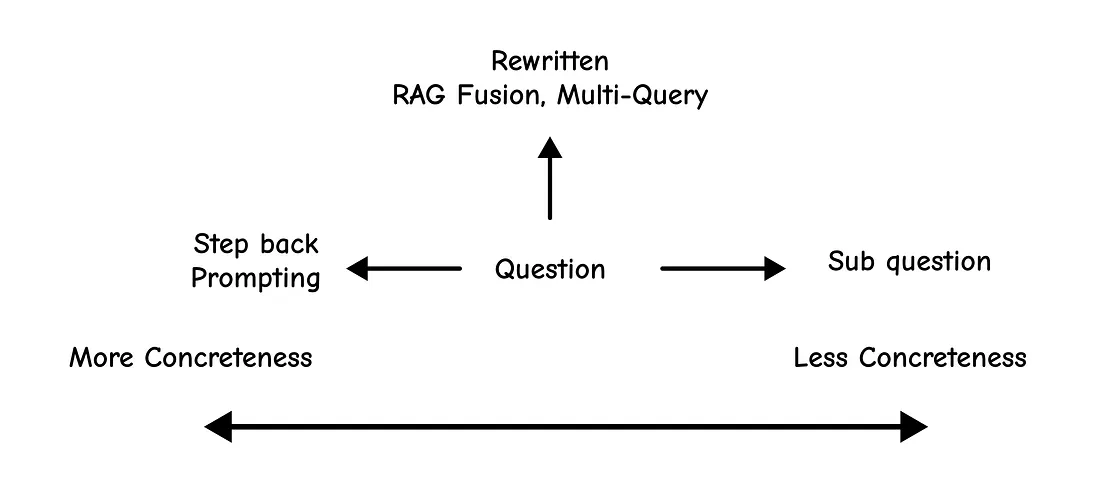)

In [115]:
# Sometimes, User’s query is too specific, while documents contain the more general Information
# The Step-Back technique uses an LLM to take a “step back” and form a more general question
# Retrieve context for both the specific and general questions, providing a richer context for the final answer.

In [116]:
# From General query from our query
# Retrieve Context for both
# Generate answer using these two

**5. Hyde**![1_YQVJMOpDBU6l54atHoFpJg[1].png](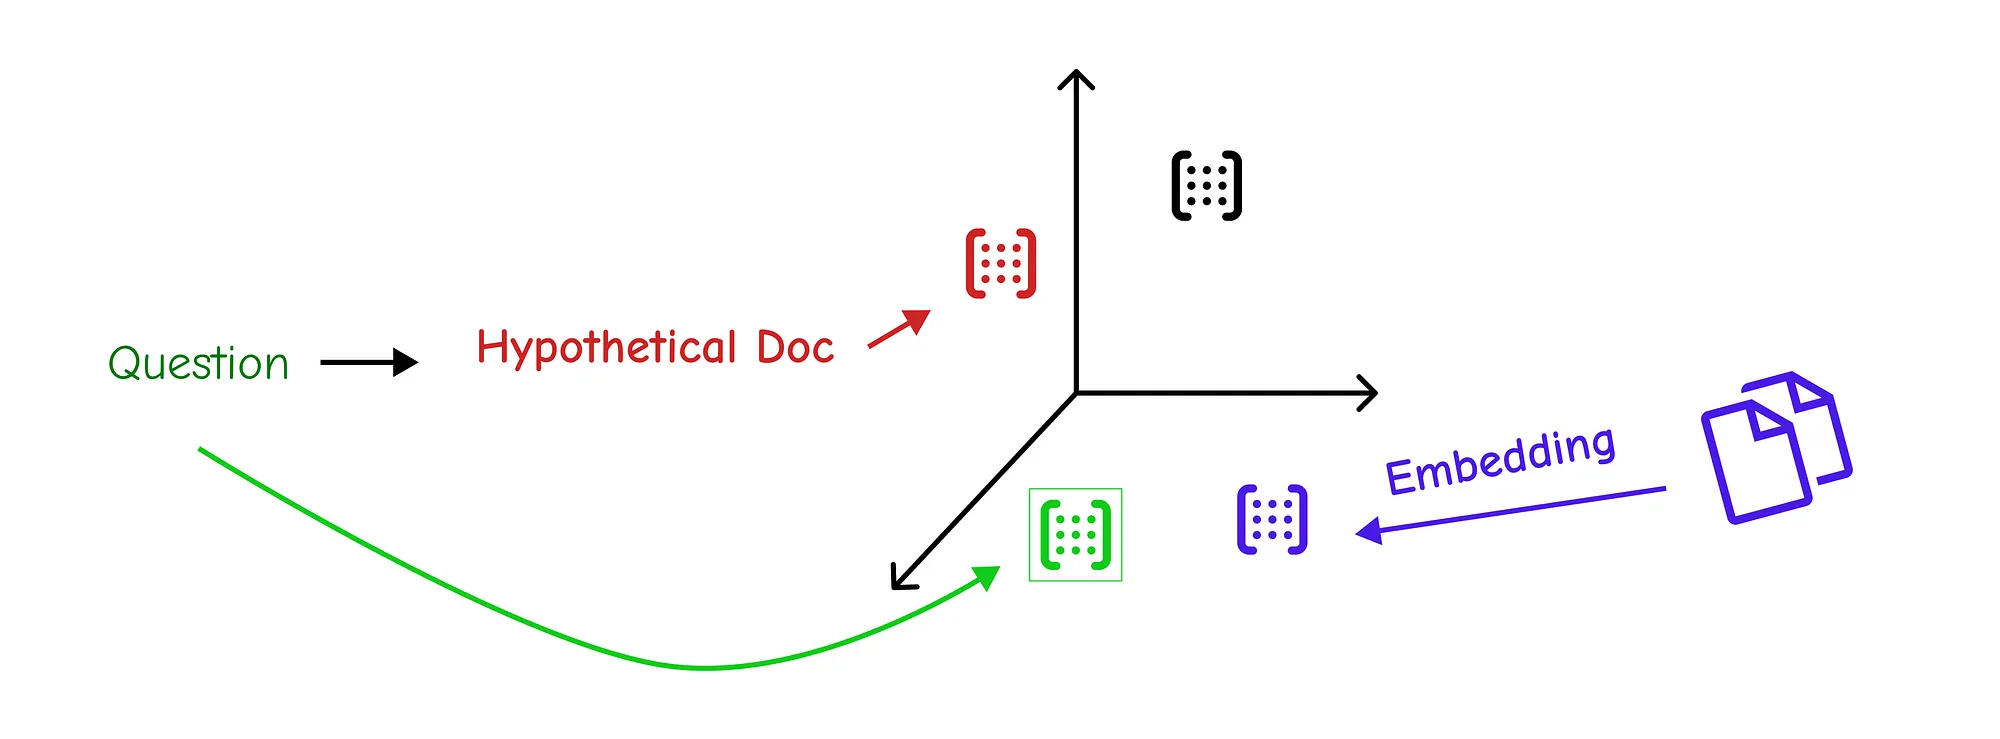)

In [118]:
# The core problem of retrieval is that a user’s query might use different words than the document
# We use Hypothetical Document Embedding to solve it
# First we generate a Hypothetical Answer for our query using LLM
# Then retrieve Documents from our vectorstore using the hypothetical Answer and Generate the answer

In [120]:
hyde_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """Please write a scientific paper passage to answer the question
Question: {question}
Passage:""")
    ]
)

In [122]:
prompt = hyde_prompt.format_messages(question=query)
prompt

[SystemMessage(content='Please write a scientific paper passage to answer the question\nQuestion: What are the main components of an LLM-powered autonomous agent system?\nPassage:', additional_kwargs={}, response_metadata={})]

In [124]:
# Generate Answer using the LLm
hyde_response = llm.invoke(prompt)
hyde_response.content

'**Title:** Architectural Components of Large Language Model (LLM)-powered Autonomous Agent Systems\n\n**Abstract:**\nThe integration of Large Language Models (LLMs) into autonomous agent systems has revolutionized the field of artificial intelligence, enabling the development of sophisticated, human-like intelligent systems. This paper provides an in-depth analysis of the main components that comprise an LLM-powered autonomous agent system, highlighting the critical roles of each component in facilitating effective decision-making, learning, and adaptation.\n\n**Introduction:**\nAutonomous agent systems, powered by LLMs, have the potential to transform various domains, including robotics, healthcare, finance, and education. These systems leverage the capabilities of LLMs to process and analyze vast amounts of data, generate human-like responses, and make informed decisions. The architecture of an LLM-powered autonomous agent system consists of several key components, which are discuss

In [126]:
# Retrieve Documents using the Hyde_resposne
hyde_retrieve_docs = vectorstore.similarity_search(hyde_response.content)
hyde_retrieve_docs

[Document(id='d7f3c170-301b-4412-9ffe-af3c3eeb852d', metadata={}, page_content='Component Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning'),
 Document(id='4167ddd9-ce51-47a3-b69e-affccfb232ce', metadata={}, page_content='Component Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallen

In [127]:
# Creating Context from our Retrieve docs
context = ""
for doc in hyde_retrieve_docs:
  context += doc.page_content

In [129]:
# Write our prompt for llm generation
prompt = prompt_template.format_messages(context=context,query=query)

In [130]:
response = llm.invoke(prompt)
response

AIMessage(content='In an LLM-powered autonomous agent system, the main components include the Planning component, which is not explicitly mentioned in the provided text, and the Tool Use component, which is mentioned. However, based on the context, the Planning component is likely a key component.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 1017, 'total_tokens': 1071, 'completion_time': 0.211288652, 'completion_tokens_details': None, 'prompt_time': 0.118951706, 'prompt_tokens_details': None, 'queue_time': 0.045502012, 'total_time': 0.330240358}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_6b5c123dd9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b30ab-2deb-7d91-9a97-55a27e24fd96-0', usage_metadata={'input_tokens': 1017, 'output_tokens': 54, 'total_tokens': 1071})